In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing
from sklearn.manifold import SpectralEmbedding

import datafold.dynfold as dfold
import datafold.pcfold as pfold
from datafold.utils.plot import plot_pairwise_eigenvector

In [2]:
from Spectral_Embedding.spectral_embedding  import spec_emd
from Diffusion_Maps.diffusions_maps import diffusion_map

## Explore dataset "poker"

### Load and preprocess data

The dataset is much too large for any of the algorithms, so it is subsampled to the limit of ~20 000 samples previously established

In [3]:
poker = pd.read_csv('pmlb/poker/poker.tsv.gz',sep='\t')
print(poker.shape)
#subsample
np.random.seed(42)
ixs = np.random.randint(low=0, high=len(poker), size=20000)
poker_short = poker.values[ixs,:-1]/13 #normalize
poker_label = poker.values[ixs,-1]

(1025010, 11)


We also explore several preprocessing options to see if we can uncover any manifold

In [4]:
poker_hands = poker[poker.target > 0]
ixs_hands = np.random.randint(low=0, high=len(poker_hands), size=20000)
pokerh_short = poker_hands.values[ixs_hands,:-1]/13 #normalize
pokerh_label = poker_hands.values[ixs_hands,-1]

In [5]:
poker_strong_hands = poker[poker.target > 3]
print(poker_strong_hands.shape)
pokersh_data = poker_strong_hands.values[:,:-1]
pokersh_label = poker_strong_hands.values[:,-1]

(7749, 11)


### Spectral Embedding

#### `sklearn.manifold.SpectralEmbedding`

In [4]:
poker_se_nn = SpectralEmbedding(n_components=7, affinity = 'nearest_neighbors', eigen_solver = "amg").fit_transform(poker_short)

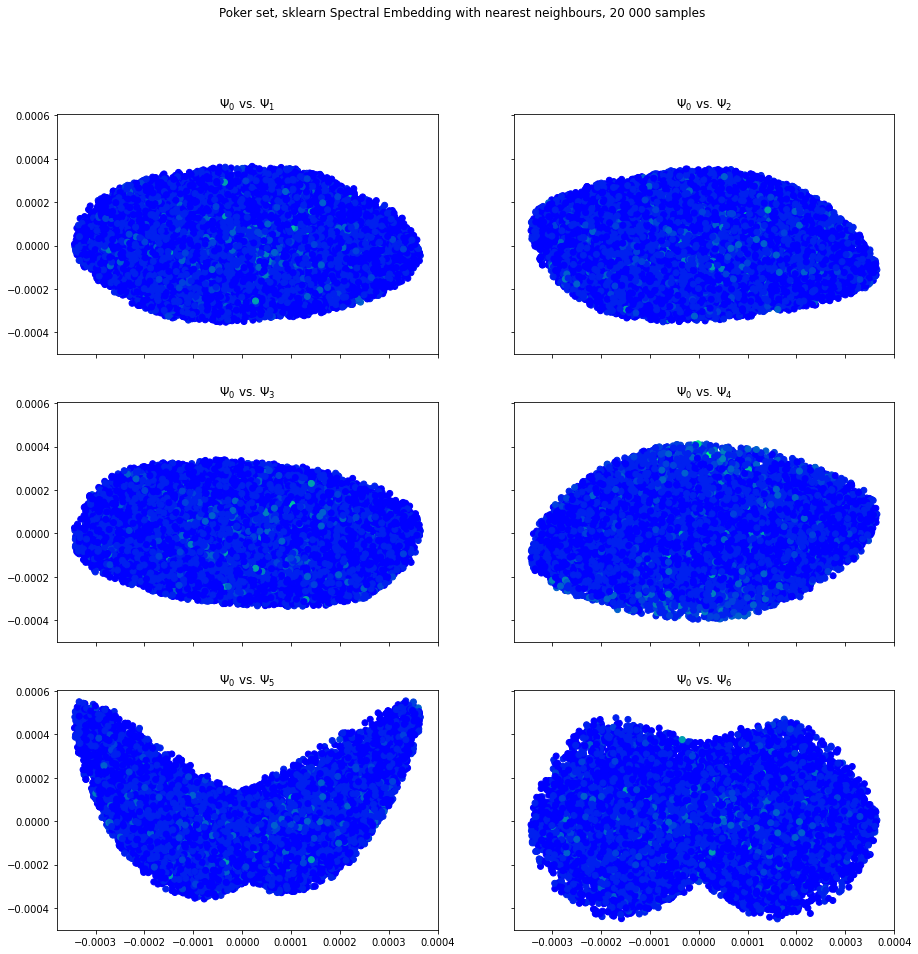

In [34]:
plot_pairwise_eigenvector(
    eigenvectors=poker_se_nn,
    n=0,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(c=poker_label, cmap='winter')
)
plt.suptitle("Poker set, sklearn Spectral Embedding with nearest neighbours, 20 000 samples");

In [7]:
%timeit -n1 -r1 SpectralEmbedding(n_components=7, affinity = 'nearest_neighbors', eigen_solver = "amg").fit_transform(poker_short)

1min 48s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [15]:
pokerh_se_nn = SpectralEmbedding(n_components=7, affinity = 'nearest_neighbors', eigen_solver = "amg").fit_transform(pokerh_short)

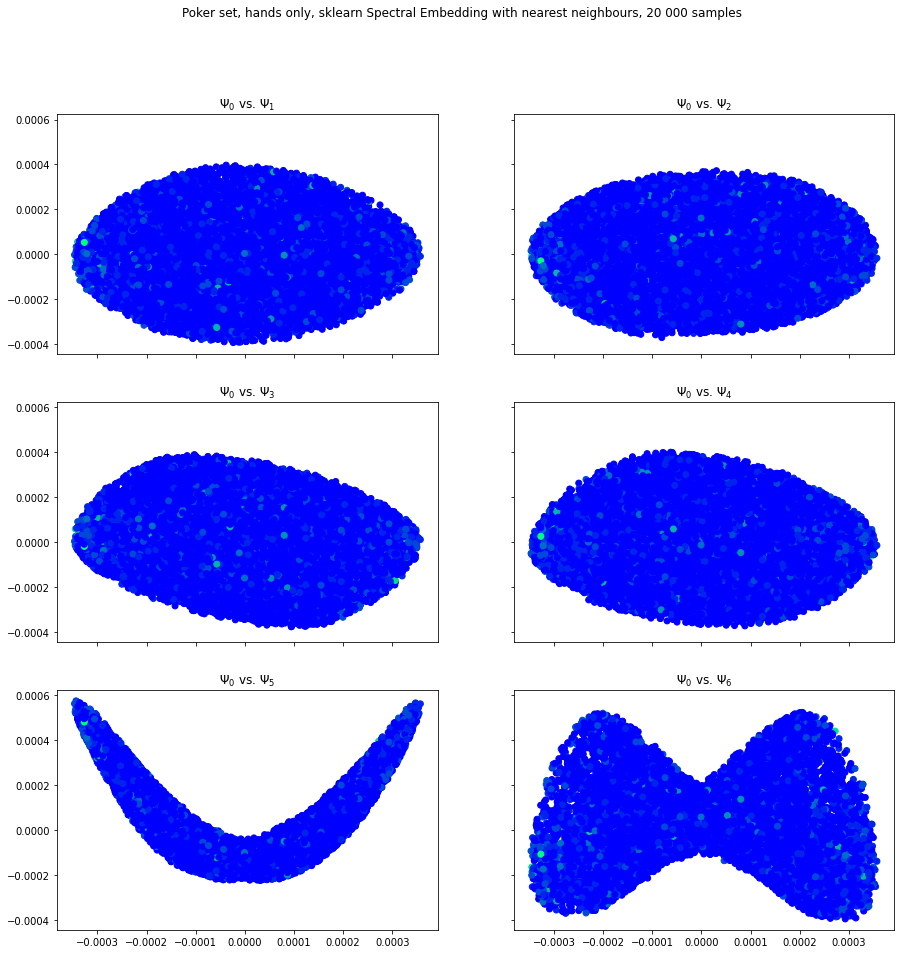

In [59]:
plot_pairwise_eigenvector(
    eigenvectors=pokerh_se_nn,
    n=0,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(c=pokerh_label, cmap='winter')
)
plt.suptitle("Poker set, hands only, sklearn Spectral Embedding with nearest neighbours, 20 000 samples");

In [38]:
pokersh_se_nn = SpectralEmbedding(n_components=7, affinity = 'nearest_neighbors', eigen_solver = "amg").fit_transform(pokersh_data)

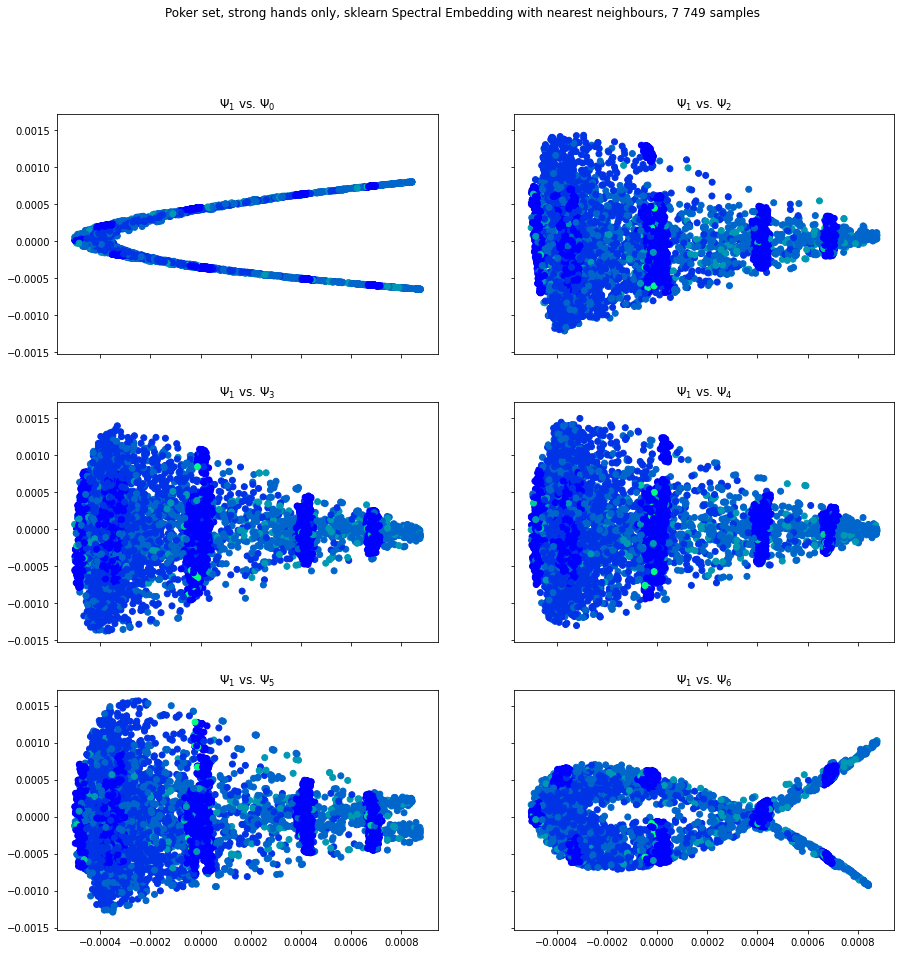

In [51]:
plot_pairwise_eigenvector(
    eigenvectors=pokersh_se_nn,
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(c=pokersh_label, cmap='winter')
)
plt.suptitle("Poker set, strong hands only, sklearn Spectral Embedding with nearest neighbours, 7 749 samples");

In [60]:
selection = dfold.LocalRegressionSelection(
    intrinsic_dim=3, n_subsample=500, strategy="dim"
).fit(pokersh_se_nn)
print(f"Found parsimonious eigenvectors (indices): {selection.evec_indices_}")

Found parsimonious eigenvectors (indices): [1 2 3]


In [6]:
%timeit -n1 -r1 pokersh_se_nn = SpectralEmbedding(n_components=7, affinity = 'nearest_neighbors', eigen_solver = "amg").fit_transform(pokersh_data)

13.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [76]:
pokersh_se_rbf = SpectralEmbedding(n_components=7, affinity = 'rbf', eigen_solver = "amg").fit_transform(pokersh_data)

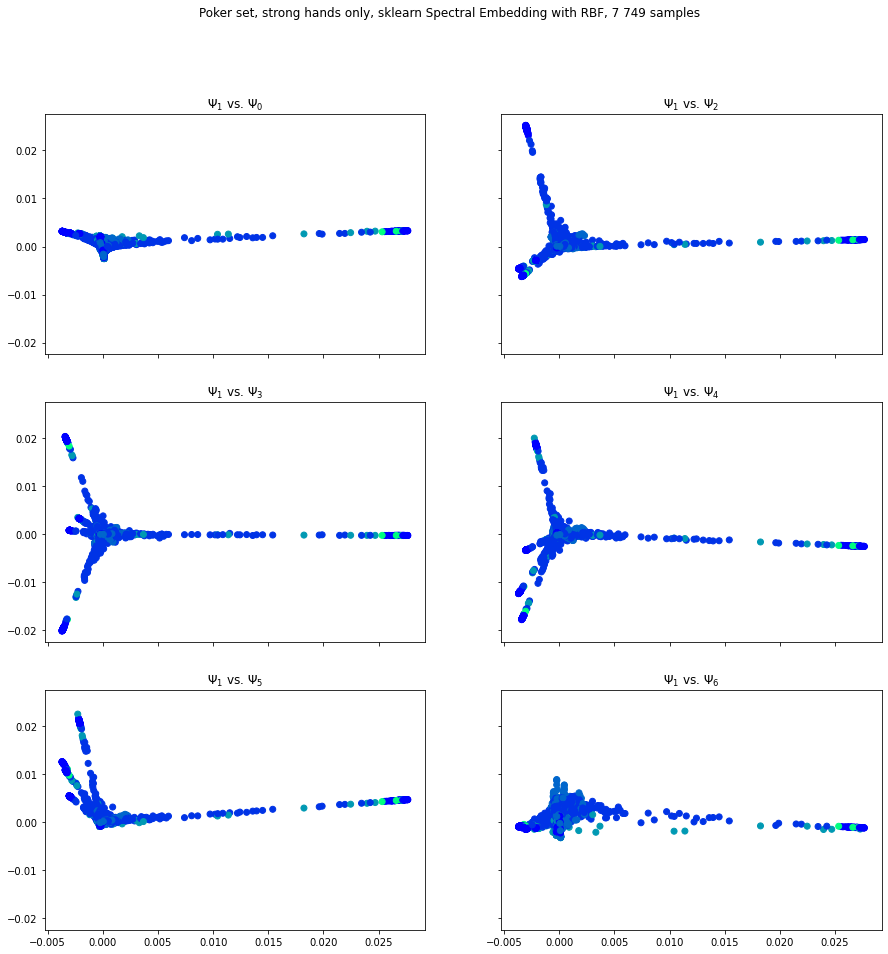

In [77]:
plot_pairwise_eigenvector(
    eigenvectors=pokersh_se_rbf,
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(c=pokersh_label, cmap='winter')
)
plt.suptitle("Poker set, strong hands only, sklearn Spectral Embedding with RBF, 7 749 samples");

In [78]:
%timeit SpectralEmbedding(n_components=7, affinity = 'rbf', eigen_solver = "amg").fit_transform(pokersh_data)

22.3 s ± 1.83 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
pokers_se_rbf = SpectralEmbedding(n_components=7, affinity = 'rbf', eigen_solver = "amg").fit_transform(poker_short[::2])

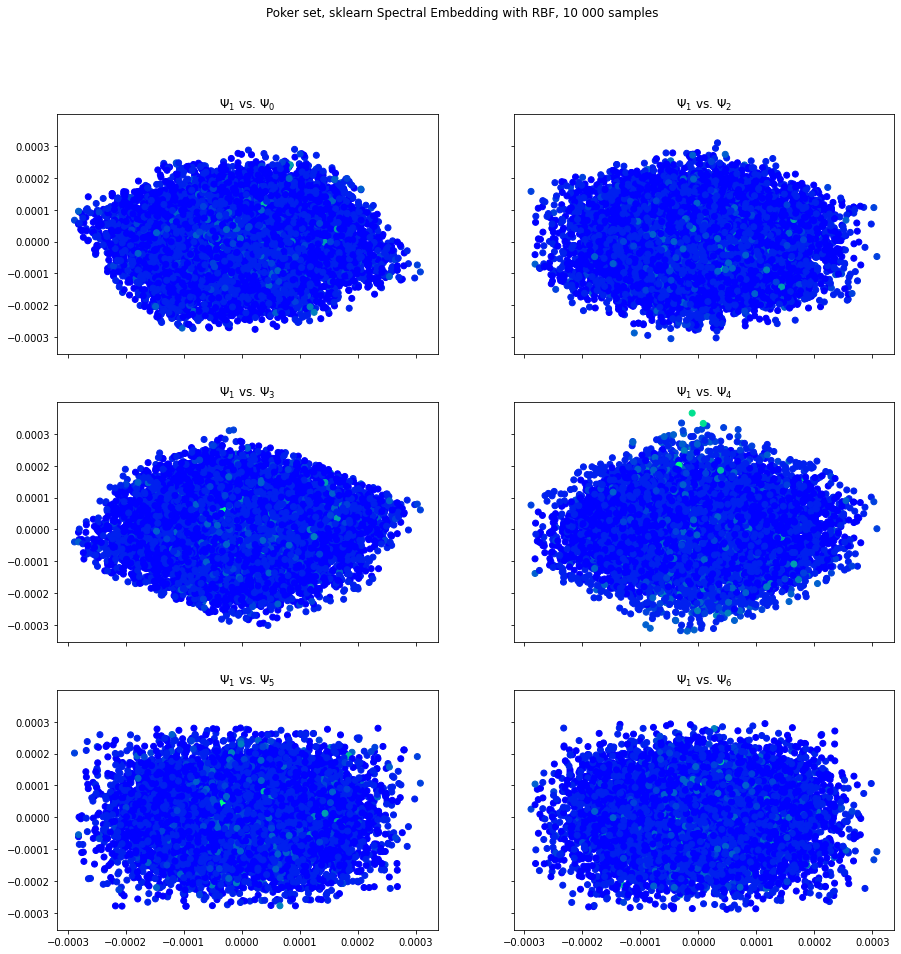

In [16]:
plot_pairwise_eigenvector(
    eigenvectors=pokers_se_rbf,
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(c=poker_label[::2], cmap='winter')
)
plt.suptitle("Poker set, sklearn Spectral Embedding with RBF, 10 000 samples");

#### Home-made Spectral Embedding

In [9]:
pokers_home_se = spec_emd(poker_short[:15001], 7)

In [11]:
%timeit -n1 -r1 pokers_home_se = spec_emd(poker_short[:15001], 7)

1min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


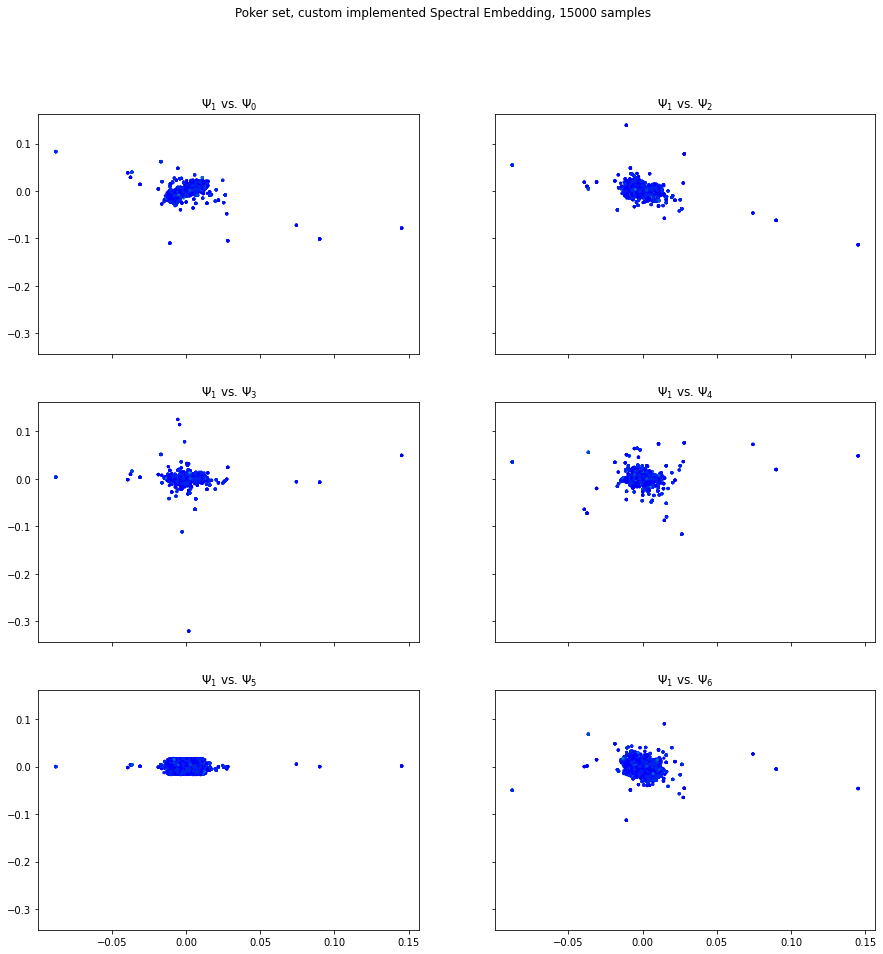

In [10]:
plot_pairwise_eigenvector(
    eigenvectors=pokers_home_se,
    n=1,
    fig_params=dict(figsize=[15, 15]),
     scatter_params=dict(s=5,c=poker_label[:15001], cmap='winter')
)
plt.suptitle("Poker set, custom implemented Spectral Embedding, 15000 samples");

### Diffusion Maps

#### `datafold.dynfold.DiffusionMaps`

In [8]:
pc_pokersh = pfold.PCManifold(pokersh_data)
pc_pokersh.optimize_parameters()

print(f"epsilon = {pc_pokersh.kernel.epsilon}, cut-off = {pc_pokersh.cut_off}")

epsilon = 2.280046029992072, cut-off = 6.48074069840786


In [17]:
pokersh_dmap_default = dfold.DiffusionMaps(
    kernel=pfold.GaussianKernel(epsilon=pc_pokersh.kernel.epsilon),
    n_eigenpairs=7,
    dist_kwargs=dict(cut_off=pc_pokersh.cut_off),
)
pokersh_dmap_default = pokersh_dmap_default.fit(pc_pokersh)

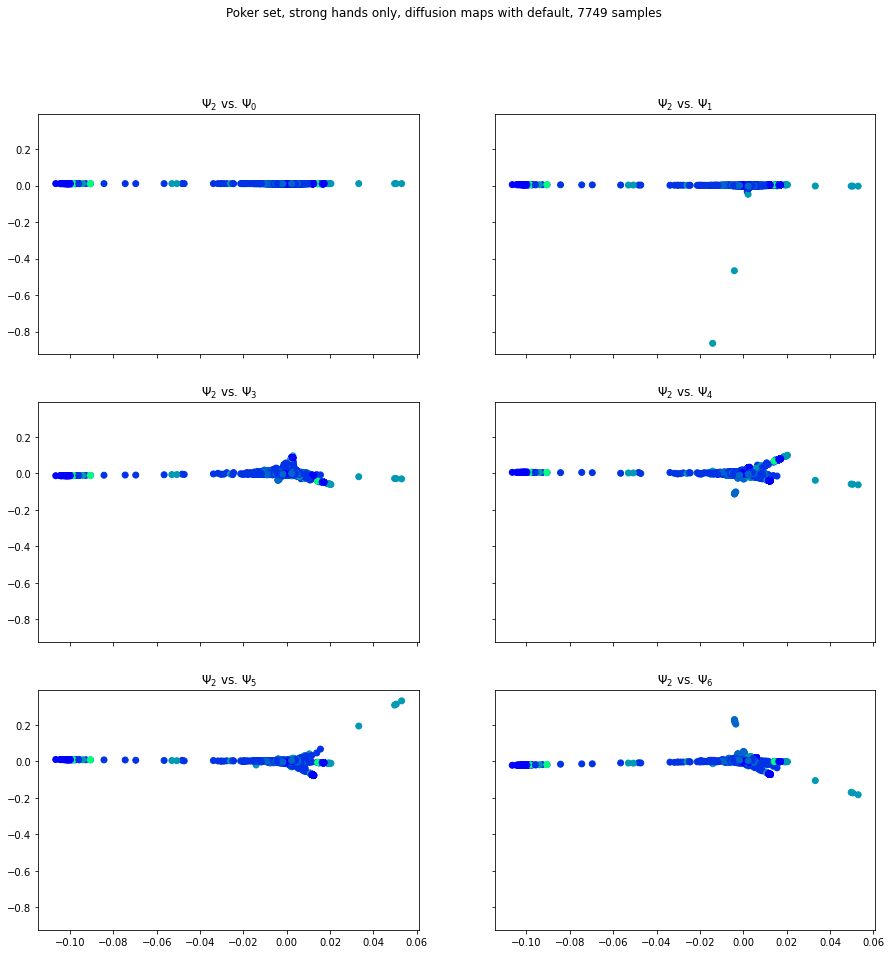

In [20]:
plot_pairwise_eigenvector(
    eigenvectors=pokersh_dmap_default.eigenvectors_,
    n=2,
    fig_params=dict(figsize=[15, 15]),
     scatter_params=dict(c=pokersh_label, cmap='winter')
)
plt.suptitle("Poker set, strong hands only, diffusion maps with default, 7749 samples");

In [62]:
%timeit -n1 -r1 pokersh_dmap_default.fit(pc_pokersh)

1min 19s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
pokersh_dmap_alpha0 = dfold.DiffusionMaps(
    kernel=pfold.GaussianKernel(epsilon=pc_pokersh.kernel.epsilon),
    n_eigenpairs=7,
    dist_kwargs=dict(cut_off=pc_pokersh.cut_off),
    alpha = 0
)
pokersh_dmap_alpha0 = pokersh_dmap_alpha0.fit(pc_pokersh)

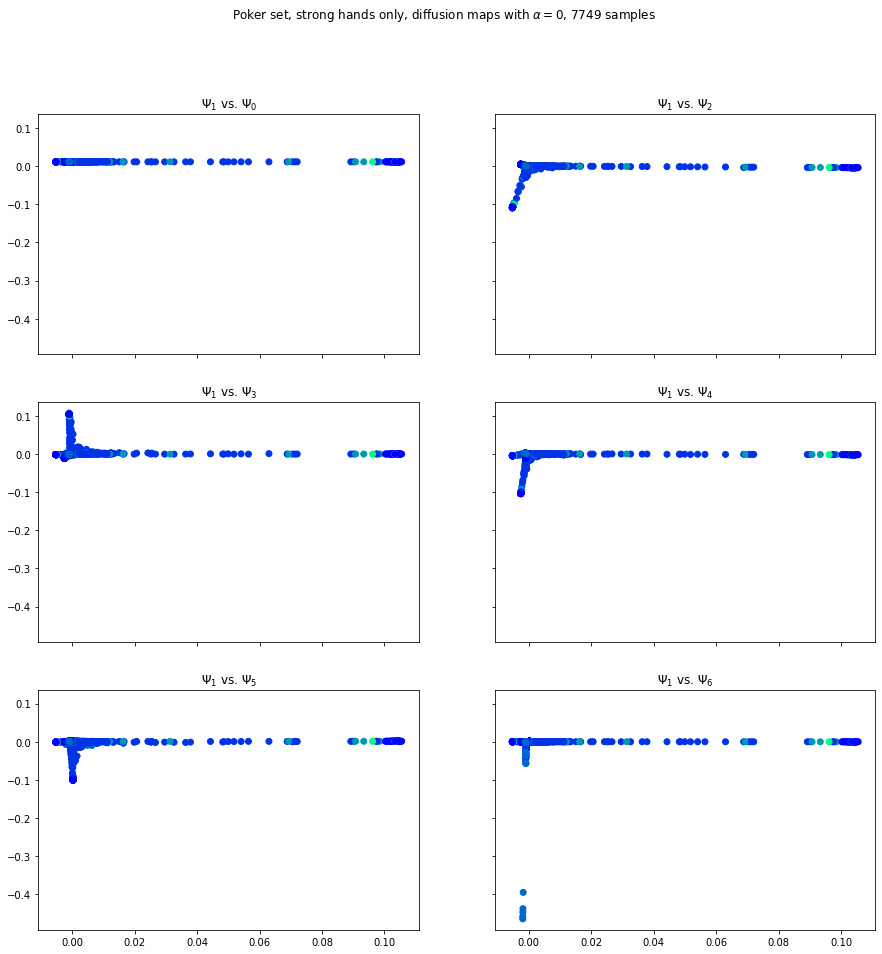

In [13]:
plot_pairwise_eigenvector(
    eigenvectors=pokersh_dmap_alpha0.eigenvectors_,
    n=1,
    fig_params=dict(figsize=[15, 15]),
     scatter_params=dict(c=pokersh_label, cmap='winter')
)
plt.suptitle(r"Poker set, strong hands only, diffusion maps with $\alpha=0$, 7749 samples");

In [11]:
pokersh_dmap_NN100 = dfold.DiffusionMaps(
    kernel=pfold.ContinuousNNKernel(100, delta=1.0),
    n_eigenpairs=7,
    dist_kwargs=dict(kmin=100),
    alpha = 0
)
pokersh_dmap_NN100 = pokersh_dmap_NN100.fit(pc_pokersh)
evecs, evals = pokersh_dmap_NN100.eigenvectors_, pokersh_dmap_NN100.eigenvalues_

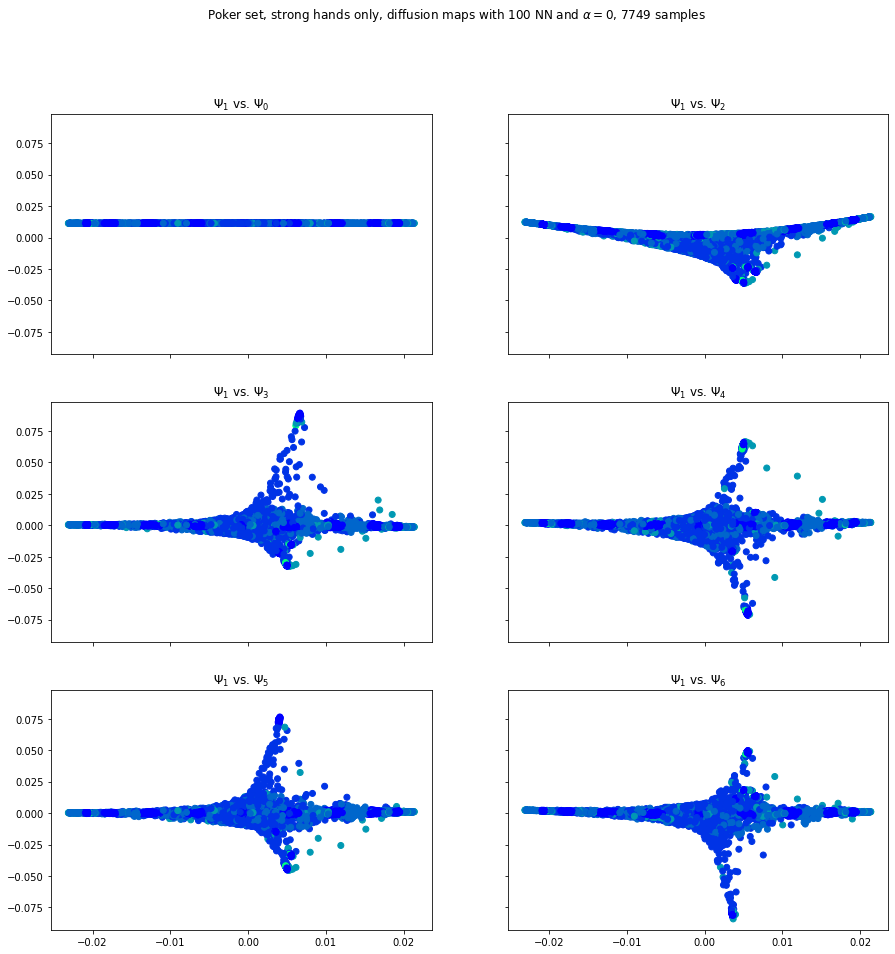

In [14]:
plot_pairwise_eigenvector(
    eigenvectors=pokersh_dmap_NN100.eigenvectors_,
    n=1,
    fig_params=dict(figsize=[15, 15]),
     scatter_params=dict(c=pokersh_label, cmap='winter')
)
plt.suptitle(r"Poker set, strong hands only, diffusion maps with 100 NN and $\alpha=0$, 7749 samples");

In [70]:
%timeit -n1 -r1 pokersh_dmap_NN100.fit(pc_pokersh)

30.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [22]:
pc_pokers = pfold.PCManifold(poker_short[::2])
pc_pokers.optimize_parameters()

print(f"epsilon = {pc_pokersh.kernel.epsilon}, cut-off = {pc_pokersh.cut_off}")

epsilon = 2.280046029992072, cut-off = 6.48074069840786


In [23]:
pokers_dmap_NN100 = dfold.DiffusionMaps(
    kernel=pfold.ContinuousNNKernel(100, delta=1.0),
    n_eigenpairs=7,
    dist_kwargs=dict(kmin=100),
    alpha = 0
)
pokers_dmap_NN100 = pokers_dmap_NN100.fit(pc_pokers)


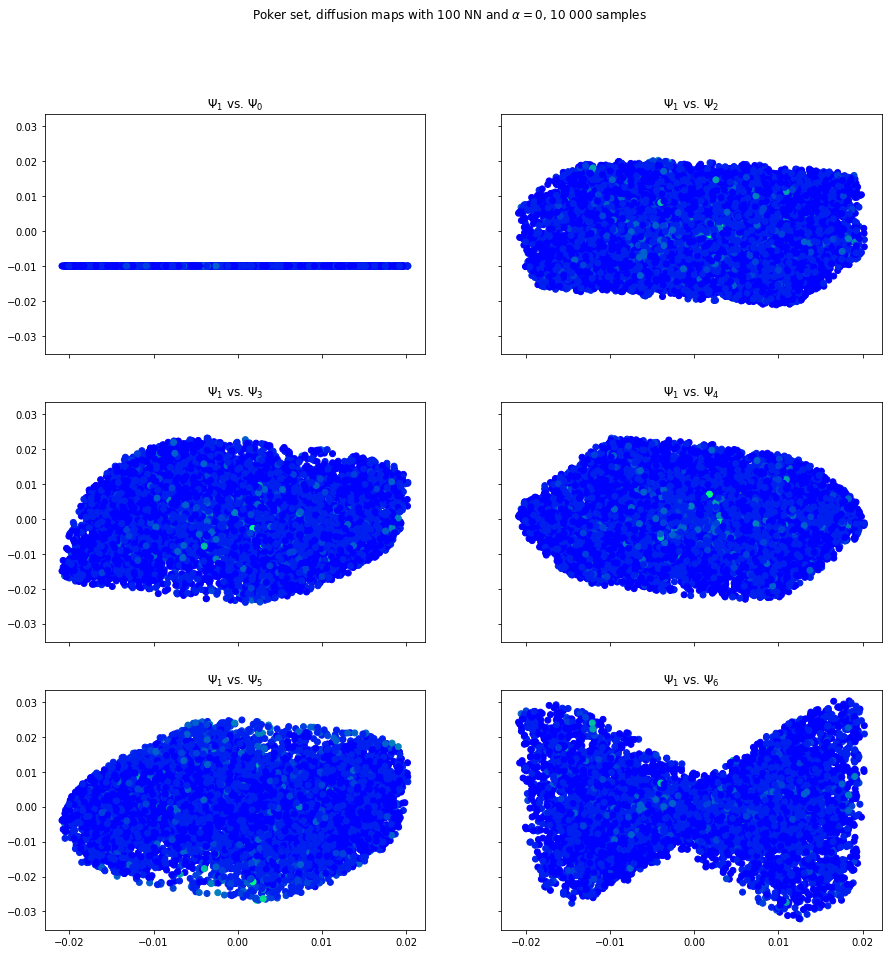

In [25]:
plot_pairwise_eigenvector(
    eigenvectors=pokers_dmap_NN100.eigenvectors_,
    n=1,
    fig_params=dict(figsize=[15, 15]),
     scatter_params=dict(c=poker_label[::2], cmap='winter')
)
plt.suptitle(r"Poker set, diffusion maps with 100 NN and $\alpha=0$, 10 000 samples");

#### Home-made diffusion maps

In [6]:
pokers_homedmap_eigval, pokers_homedmap_eigvec = diffusion_map(poker_short[:15001], 7)

In [12]:
%timeit -n1 -r1  diffusion_map(poker_short[:15001], 7)

23min 52s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


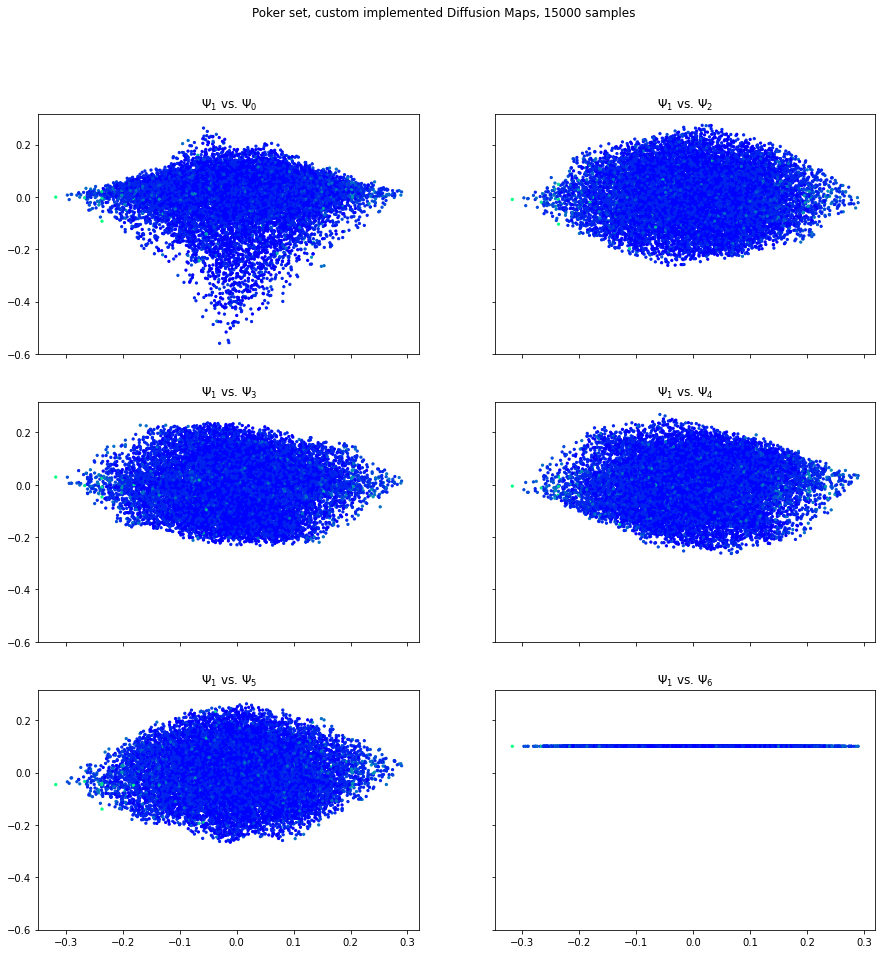

In [8]:
plot_pairwise_eigenvector(
    eigenvectors=pokers_homedmap_eigvec,
    n=1,
    fig_params=dict(figsize=[15, 15]),
     scatter_params=dict(s=5,c=poker_label[:15001], cmap='winter')
)
plt.suptitle("Poker set, custom implemented Diffusion Maps, 15000 samples");

## Explore dataset "magic"

### Load and preprocess data

In [7]:
magic = pd.read_csv('pmlb/magic/magic.tsv.gz', sep='\t')
print(magic.shape)
magic_data = magic.values[:,:-1]
magic_label = magic.values[:,-1]
magic_norm = sklearn.preprocessing.StandardScaler().fit_transform(magic_data)
magic_short =  magic_norm[::4]
print(magic_short.shape)
magic_slabel = magic_label[::4]

(19020, 11)
(4755, 10)


### Spectral Embedding

#### `sklearn.manifold.SpectralEmbedding`

In [13]:
magic_se_nn = SpectralEmbedding(n_components=7, affinity = 'nearest_neighbors', eigen_solver = "amg").fit_transform(magic_data)

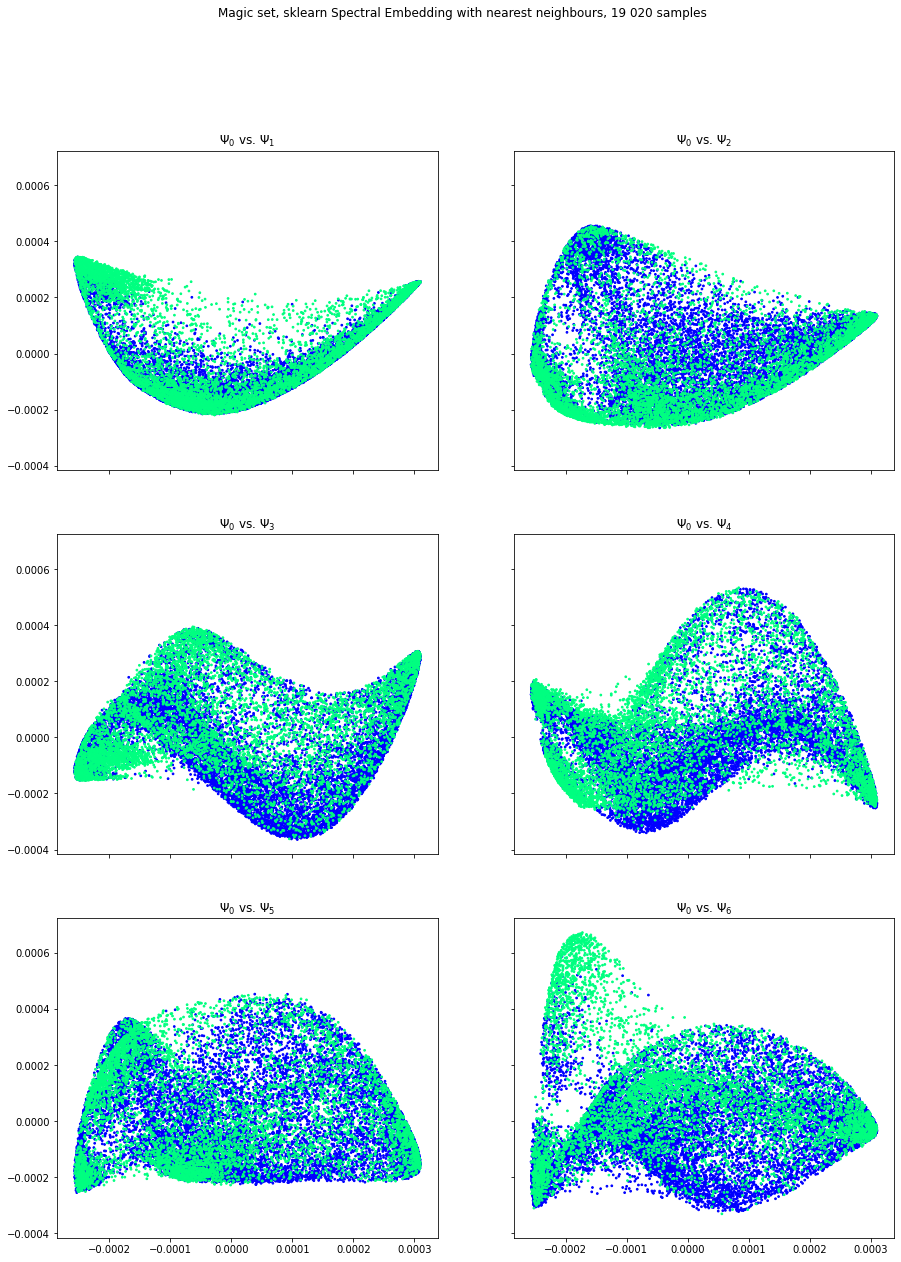

In [16]:
plot_pairwise_eigenvector(
    eigenvectors=magic_se_nn,
    n=0,
    fig_params=dict(figsize=[15, 20]),
    scatter_params=dict(s=3, c=magic_label, cmap='winter')
)
plt.suptitle("Magic set, sklearn Spectral Embedding with nearest neighbours, 19 020 samples");

In [8]:
%timeit -n1 -r1 magics_se_nn = SpectralEmbedding(n_components=7, affinity = 'nearest_neighbors', eigen_solver = "amg").fit_transform(magic_data)

1min 17s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [28]:
magics_se_nn = SpectralEmbedding(n_components=7, affinity = 'nearest_neighbors', eigen_solver = "amg").fit_transform(magic_short)

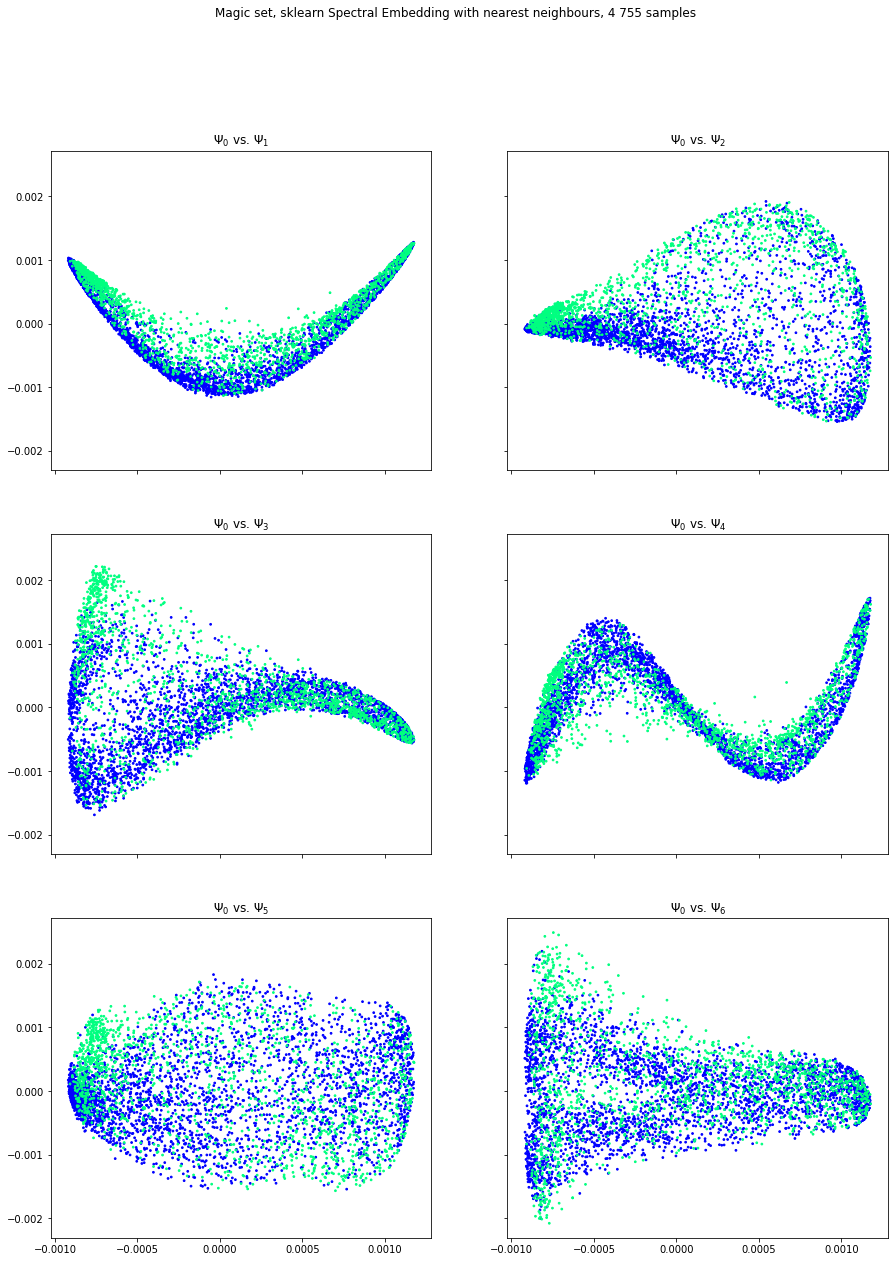

In [23]:
plot_pairwise_eigenvector(
    eigenvectors=magics_se_nn,
    n=0,
    fig_params=dict(figsize=[15, 20]),
    scatter_params=dict(s=3, c=magic_slabel, cmap='winter')
)
plt.suptitle("Magic set, sklearn Spectral Embedding with nearest neighbours, 4 755 samples");

In [26]:
magics_se_rbf = SpectralEmbedding(n_components=7, affinity = 'rbf', eigen_solver = "amg").fit_transform(magic_short)

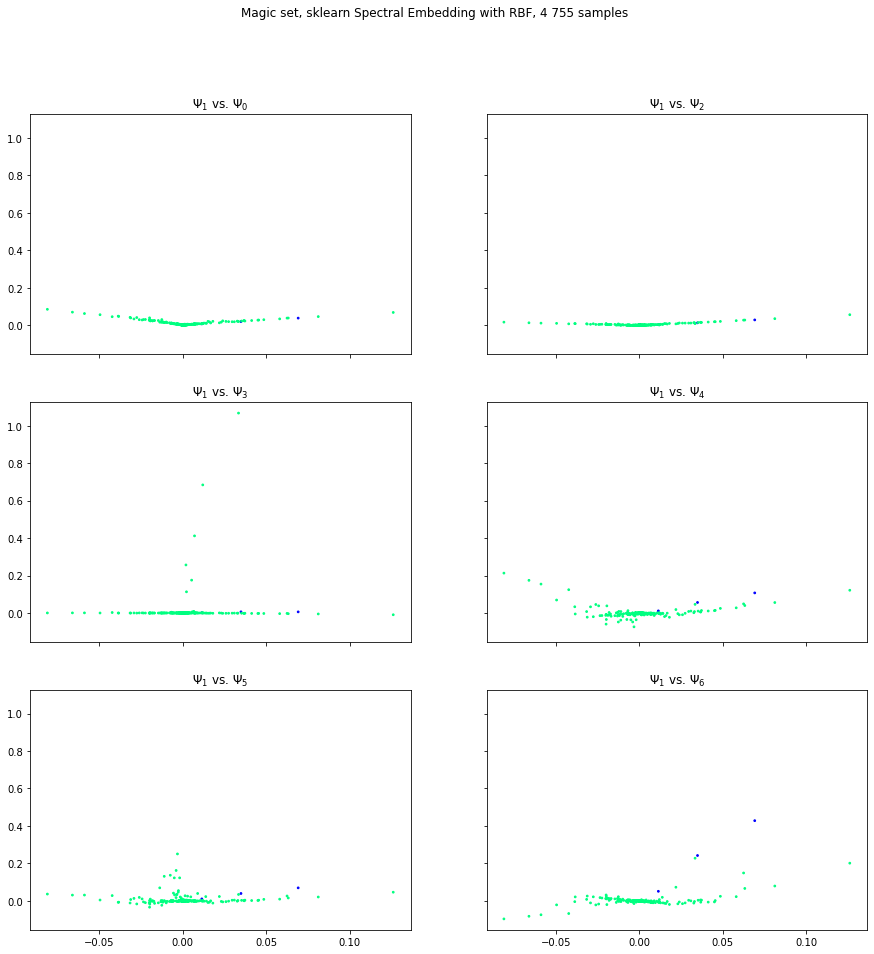

In [60]:
plot_pairwise_eigenvector(
    eigenvectors=magics_se_rbf,
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(s=3, c=magic_slabel, cmap='winter')
)
plt.suptitle("Magic set, sklearn Spectral Embedding with RBF, 4 755 samples");

#### Home-made Spectral Embedding

In [46]:
%timeit -n1 -r1 spec_emd(magic_short[::2], 7)

18.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [15]:
magics_home_se = spec_emd(magic_short[::2], 7)

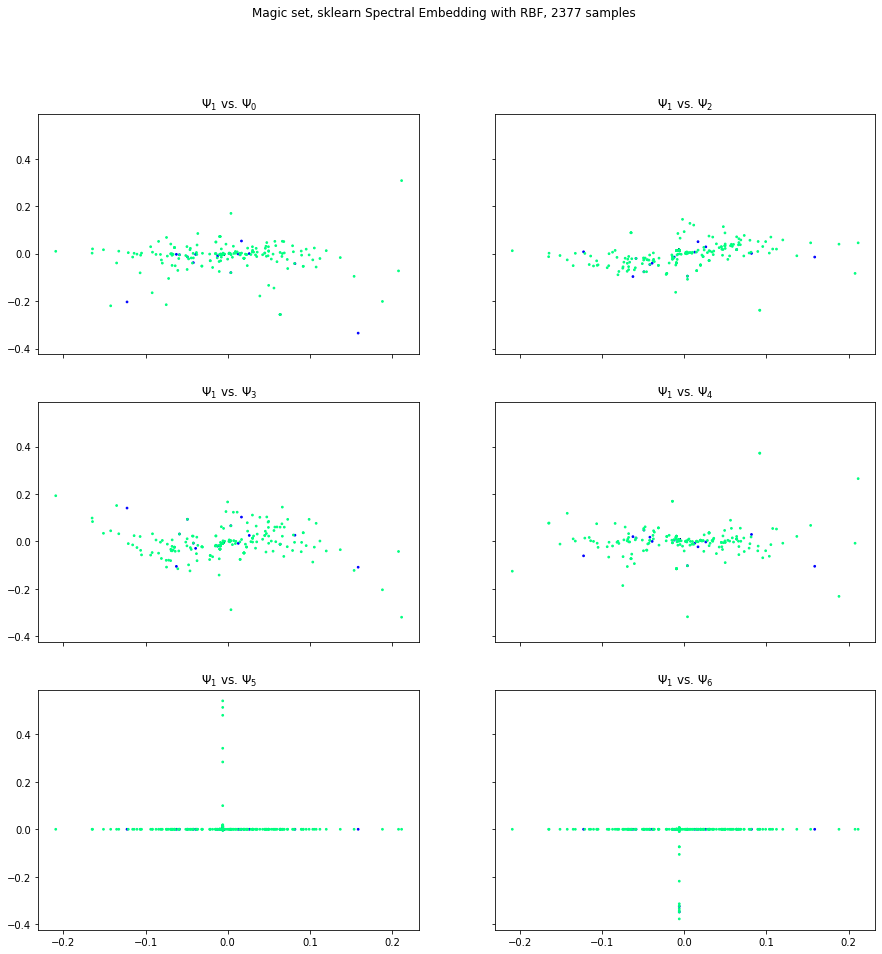

In [59]:
plot_pairwise_eigenvector(
    eigenvectors=magics_home_se,
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(s=3, c=magic_slabel[::2], cmap='winter')
)
plt.suptitle(f"Magic set, sklearn Spectral Embedding with RBF, {4755//2} samples");

### Diffusion Maps

#### `datafold.dynfold.DiffusionMaps`

In [47]:
pc_magics = pfold.PCManifold(magic_short)
pc_magics.optimize_parameters()

print(f"epsilon = {pc_magics.kernel.epsilon}, cut-off = {pc_magics.cut_off}")

epsilon = 2.502945934164058, cut-off = 6.7901375518180584


In [52]:
magics_dmap_default = dfold.DiffusionMaps(
    kernel=pfold.GaussianKernel(epsilon=pc_magics.kernel.epsilon),
    n_eigenpairs=7,
    dist_kwargs=dict(cut_off=pc_magics.cut_off),
)
magics_dmap_default = magics_dmap_default.fit(magic_short)

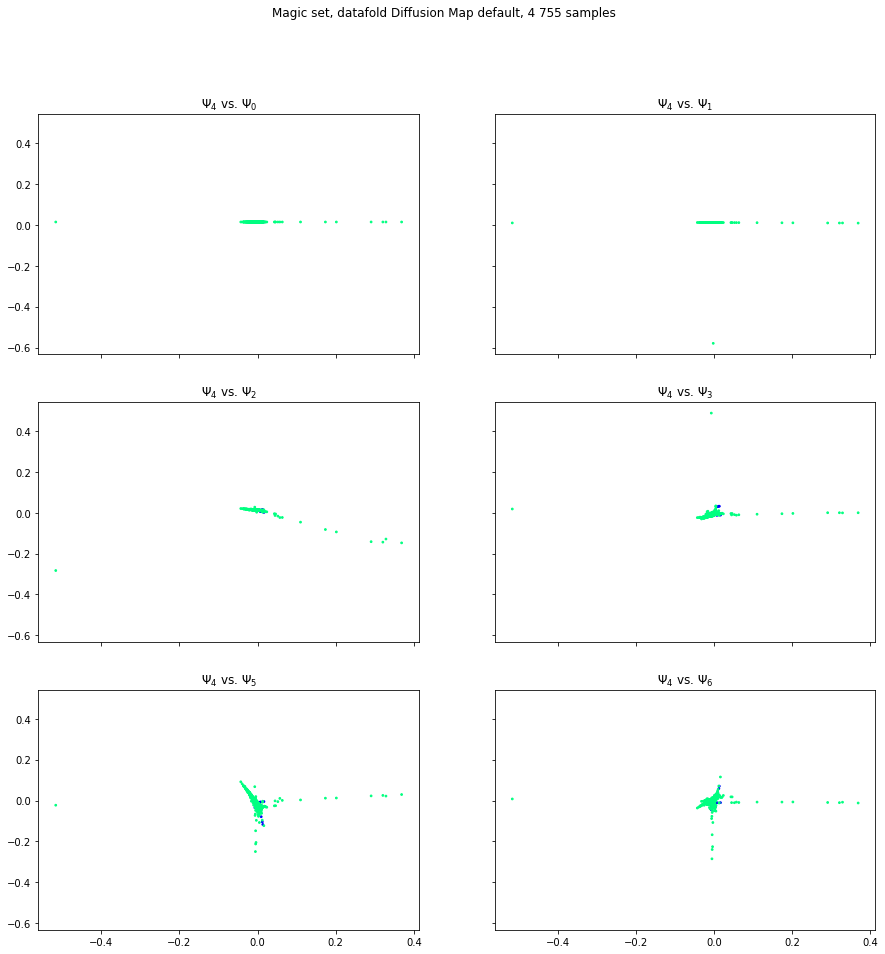

In [58]:
plot_pairwise_eigenvector(
    eigenvectors=magics_dmap_default.eigenvectors_,
    n=4,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(s=3, c=magic_slabel, cmap='winter')
)
plt.suptitle("Magic set, datafold Diffusion Map default, 4 755 samples");

In [50]:
%timeit -n1 -r1 magics_dmap_default.fit(magic_short)

24.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [54]:
magics_dmap_NN100 = dfold.DiffusionMaps(
    kernel=pfold.ContinuousNNKernel(100, delta=1.0),
    n_eigenpairs=7,
    dist_kwargs=dict(kmin=100),
    alpha = 0
)
magics_dmap_NN100 = magics_dmap_NN100.fit(magic_short)

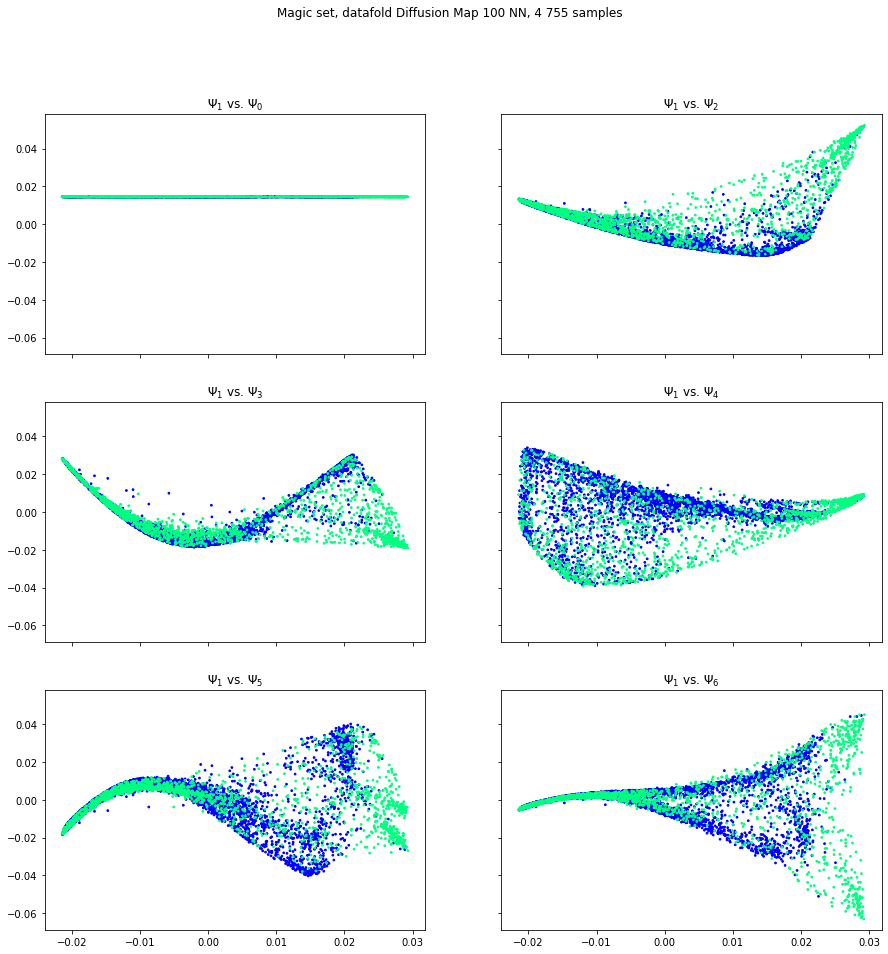

In [56]:
plot_pairwise_eigenvector(
    eigenvectors=magics_dmap_NN100.eigenvectors_,
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(s=3, c=magic_slabel, cmap='winter')
)
plt.suptitle("Magic set, datafold Diffusion Map 100 NN, 4 755 samples");

In [11]:
magic_dmap_NN100 = dfold.DiffusionMaps(
    kernel=pfold.ContinuousNNKernel(100, delta=1.0),
    n_eigenpairs=7,
    dist_kwargs=dict(kmin=100),
    alpha = 0
)
magic_dmap_NN100 = magic_dmap_NN100.fit(magic_data[::2])

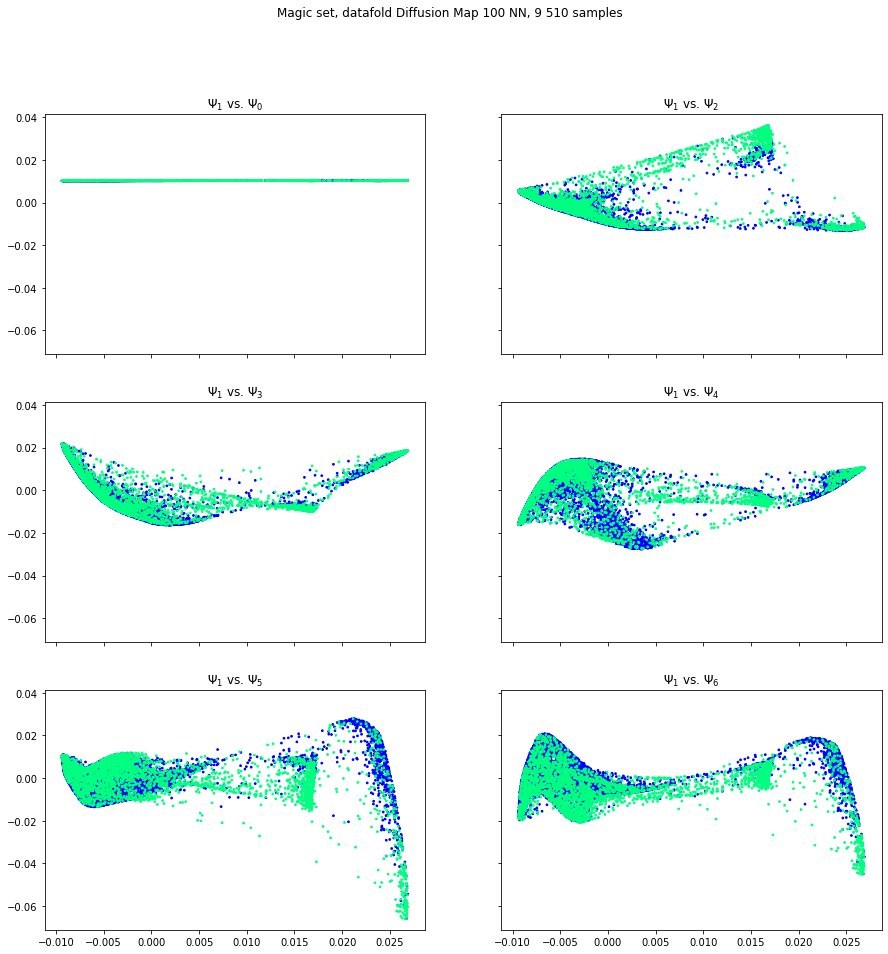

In [15]:
plot_pairwise_eigenvector(
    eigenvectors=magic_dmap_NN100.eigenvectors_,
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(s=3, c=magic_label[::2], cmap='winter')
)
plt.suptitle("Magic set, datafold Diffusion Map 100 NN, 9 510 samples");

#### Home-made diffusion maps

In [17]:
magics_homedmap_eigval, magics_homedmap_eigvec = diffusion_map(magic_short[::3], 7)

ArpackNoConvergence: ARPACK error -1: No convergence (15851 iterations, 0/7 eigenvectors converged)